https://medium.com/analytics-vidhya/data-analysis-end-to-end-imdb-dataset-2b6d9976ebc2

https://www.kaggle.com/code/xshaimaa/tmdb-movie-dataset-analysis

https://www.kaggle.com/code/deepak525/investigate-tmdb-movie-dataset/notebook

decades

https://www.kaggle.com/code/fabiendaniel/film-recommendation-engine

In [96]:
import json
import warnings
from datetime import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 70)

In [98]:
def count_nan_values(dataframe, column_name):
    nan_count = dataframe[column_name].isna().sum()
    print(f"Number of NaN values in '{column_name}': {nan_count}")

# 1. Data loading and gain info

1. Exploration
First, we define a few functions to create an interface with the new structure of the dataset. The code below is entirely taken from Sohier's kernel:

In [99]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [100]:
# Columns that existed in the IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

In [101]:
# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

In [7]:
def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [102]:
movies = load_tmdb_movies("tmdb_5000_movies.csv")
credits = load_tmdb_credits("tmdb_5000_credits.csv")
main_df = convert_to_original_format(movies, credits)

In [103]:
main_df.head()

,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton


In [104]:
main_df.to_csv('data.csv', index=False)

### Features Description

1. **budget**: The budget allocated for producing the movie.
2. **genres**: The genre(s) to which the movie belongs.
3. **homepage**: The URL of the movie's official website, if available.
4. **id**: Unique identifier for each movie in the dataset.
5. **plot_keywords**: Keywords describing the plot or themes of the movie.
6. **language**: The language(s) in which the movie is primarily spoken.
7. **original_title**: The original title of the movie.
8. **overview**: A brief summary or description of the movie.
9. **popularity**: Popularity score of the movie.
10. **production_companies**: Companies involved in producing the movie.
11. **production_countries**: Countries where the movie was produced.
12. **release_date**: The date when the movie was released.
13. **gross**: The gross revenue generated by the movie.
14. **duration**: The duration or length of the movie.
15. **spoken_languages**: Languages spoken in the movie.
16. **status**: The status of the movie (e.g., released, in production).
17. **tagline**: A memorable phrase or slogan associated with the movie.
18. **movie_title**: The title of the movie.
19. **vote_average**: The average rating given to the movie by users.
20. **num_voted_users**: The number of users who voted/rated the movie.
21. **title_year**: The year when the movie was released.
22. **country**: The country where the movie was primarily produced.
23. **director_name**: The name of the movie's director.
24. **actor_1_name**: The name of the primary actor in the movie.
25. **actor_2_name**: The name of the secondary actor in the movie.
26. **actor_3_name**: The name of another actor in the movie.


# 2. Data cleaning and Preprocessing

In [105]:
df_preprocessed = main_df.copy()

## 2.1 Check for duplicates

In [106]:
# Specify columns to check for duplicate
columns_to_check = ['id', 'original_title']

# Check for duplicates
duplicates = df_preprocessed.duplicated(subset=columns_to_check)

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Display the duplicates
if num_duplicates > 0:
    print("Number of duplicates found:", num_duplicates)
    print(df_preprocessed[duplicates])
else:
    print("No duplicates found.")


No duplicates found.


## 2.2 Remove extra columns

In [107]:
columns_to_drop = ['homepage', 'id', 'spoken_languages', 'status', 'movie_title', 'title_year']
df_preprocessed.drop(columns_to_drop, axis=1, inplace=True)

In [14]:
df_preprocessed.head()

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,Enter the World of Pandora.,7.2,11800,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver
1,300000000,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley
2,245000000,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,A Plan No One Escapes,6.3,4466,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux
3,250000000,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,The Legend Ends,7.6,9106,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman
4,260000000,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"Lost in our world, found in another.",6.1,2124,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton


## 2.3 Check Columns 

### 2.3.1 budget and gross

In [108]:
df_preprocessed[['budget', 'gross']]

,budget,gross
0,237000000,2787965087
1,300000000,961000000
2,245000000,880674609
3,250000000,1084939099
4,260000000,284139100
...,...,...
4798,220000,2040920
4799,9000,0
4800,0,0
4801,0,0


#### Reducing digits for better readability

The numbers in the budget and gross are too big, compromising its readability. Let's convert the unit of the budget and gross columns from dollor to million dollor first.

In [109]:
# Convert budget and gross columns to million dollars
df_preprocessed['budget'] = main_df['budget'] / 1000000
df_preprocessed['gross'] = main_df['gross'] / 1000000

# Print the first few rows to verify the conversion
df_preprocessed[['budget', 'gross']].tail()

,budget,gross
4798,0.220,2.04092
4799,0.009,0.00000
4800,0.000,0.00000
4801,0.000,0.00000
4802,0.000,0.00000


#### Check for missing values in the 'budget' column

In [110]:
# Check for missing values in the 'budget' column
missing_values = main_df['budget'].isnull().sum()

if missing_values > 0:
    print("There are", missing_values, "missing values in the 'budget' column.")
else:
    print("There are no missing values in the 'budget' column.")

There are no missing values in the 'budget' column.


In [111]:
# Check for missing values in the 'gross' column
missing_values = main_df['gross'].isnull().sum()

if missing_values > 0:
    print("There are", missing_values, "missing values in the 'gross' column.")
else:
    print("There are no missing values in the 'gross' column.")

There are no missing values in the 'gross' column.


#### Check for negative values in the 'budget' column

In [112]:
# Check for negative values in the 'budget' column
negative_budget = (df_preprocessed['budget'] < 0).sum()

if negative_budget > 0:
    print("There are", negative_budget, "negative values in the 'budget' column.")
else:
    print("There are no negative values in the 'budget' column.")


There are no negative values in the 'budget' column.


#### Check for negative values in the 'gross' column

In [113]:
# Check for negative values in the 'budget' column
negative_budget = (df_preprocessed['gross'] < 0).sum()

if negative_budget > 0:
    print("There are", negative_budget, "negative values in the 'gross' column.")
else:
    print("There are no negative values in the 'gross' column.")


There are no negative values in the 'gross' column.


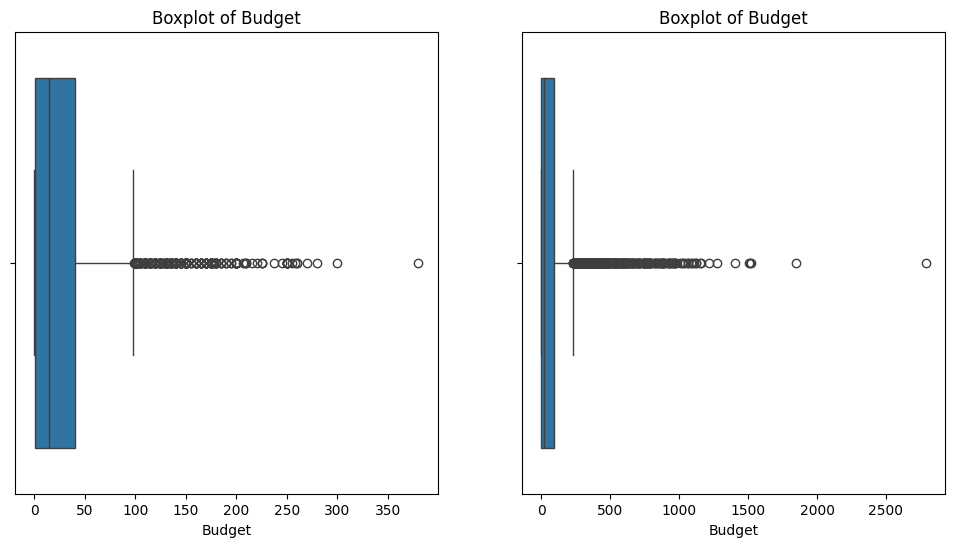

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplot to visualize outliers in the 'budget' column
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

sns.boxplot(x=df_preprocessed['budget'])
plt.title('Boxplot of Budget')
plt.xlabel('Budget')


plt.subplot(1,2,2)

sns.boxplot(x=df_preprocessed['gross'])
plt.title('Boxplot of Budget')
plt.xlabel('Budget')
plt.show()

In [22]:
df_preprocessed['budget']

0       237.000
1       300.000
2       245.000
3       250.000
4       260.000
         ...   
4798      0.220
4799      0.009
4800      0.000
4801      0.000
4802      0.000
Name: budget, Length: 4803, dtype: float64

In [237]:
# Define quartile thresholds for categorization
low_threshold = df_preprocessed['budget'].quantile(0.25)
high_threshold = df_preprocessed['budget'].quantile(0.75)

# Categorize budget
df_preprocessed['budget_categorized'] = np.where(df_preprocessed['budget'] < low_threshold, 'low',
                                    np.where(df_preprocessed['budget'] <= high_threshold, 'average', 'high'))

# Display the DataFrame with the new column
df_preprocessed['budget_categorized'].value_counts()


budget_categorized
average    2456
low        1146
high       1115
Name: count, dtype: int64

In [24]:
# Count the number of entries where budget is equal to 0
num_zero_budget = (main_df['budget'] == 0).sum()

print("Number of entries where budget is equal to 0:", num_zero_budget)


Number of entries where budget is equal to 0: 1037


In [25]:
df_zero_budget = main_df[main_df['budget'] == 0]

In [26]:
# Count the number of entries where budget is equal to 0
num_zero_gross = (df_zero_budget['gross'] == 0).sum()

print("Number of entries where gross is equal to 0:", num_zero_gross)

Number of entries where gross is equal to 0: 890


If some entries have a budget of 0 but a non-zero gross, it could be due to various reasons:

1. **Missing or Incomplete Data:** Sometimes, budget data might be missing or incomplete, leading to a value of 0. However, the movie could still generate revenue, resulting in a non-zero gross.

2. **Low-budget or Independent Films:** Some low-budget or independent films might have minimal or no budget recorded, especially if they are self-funded or financed through alternative means. However, these films can still generate revenue through ticket sales, distribution deals, or other sources.


### make profit column

In [114]:
# make profit column
df_preprocessed['profit'] = df_preprocessed['gross'] - df_preprocessed['budget']

In [123]:
# Calculate 10% of the budget
threshold = 0.1 * df_preprocessed['budget']

# Categorize profit
df_preprocessed['profit_categorized'] = np.where(df_preprocessed['profit'] > threshold, 'profit', 'no profit')

In [124]:
df_preprocessed['profit_categorized'].value_counts()

profit_categorized
profit       2515
no profit    2288
Name: count, dtype: int64

### 2.3.2 genres

In [125]:
main_df['genres']

0       Action|Adventure|Fantasy|Science Fiction
1                       Adventure|Fantasy|Action
2                         Action|Adventure|Crime
3                    Action|Crime|Drama|Thriller
4               Action|Adventure|Science Fiction
                          ...                   
4798                       Action|Crime|Thriller
4799                              Comedy|Romance
4800               Comedy|Drama|Romance|TV Movie
4801                                            
4802                                 Documentary
Name: genres, Length: 4803, dtype: object

In [126]:
from sklearn.preprocessing import MultiLabelBinarizer

In [127]:
# Split the genre strings into lists of genres
genres_list = df_preprocessed['genres'].str.split('|').tolist()

# Flatten the list of lists into a single list
all_genres = [genre for sublist in genres_list for genre in sublist]

# Get unique genres
unique_genres = list(set(all_genres))

print("List of all genres in the DataFrame:")
print(unique_genres)

List of all genres in the DataFrame:
['', 'Family', 'Romance', 'Western', 'Fantasy', 'Comedy', 'Music', 'Drama', 'Science Fiction', 'TV Movie', 'War', 'Crime', 'History', 'Thriller', 'Horror', 'Documentary', 'Mystery', 'Animation', 'Adventure', 'Action', 'Foreign']


In [128]:
genres_str = main_df['genres']

# Split the genres string into lists of genres
genres_split = genres_str.str.split('|')

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genres
genres_encoded = mlb.fit_transform(genres_split)

# Convert the encoded genres into a DataFrame for easier manipulation
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Concatenate the encoded genres DataFrame with your original DataFrame
df_preprocessed = pd.concat([df_preprocessed, genres_df], axis=1)

In [129]:
df_preprocessed.head()

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,237.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787.965087,162.0,Enter the World of Pandora.,7.2,11800,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,2550.965087,profit,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,300.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961.000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,661.000000,profit,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,245.0,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880.674609,148.0,A Plan No One Escapes,6.3,4466,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,635.674609,profit,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,250.0,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084.939099,165.0,The Legend Ends,7.6,9106,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,834.939099,profit,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,260.0,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284.139100,132.0,"Lost in our world, found in another.",6.1,2124,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,24.139100,no profit,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [130]:
genre_counts = genres_df.sum()

# Print the count of each genre
for genre, count in zip(genres_df.columns, genre_counts):
    print(f"{genre}: {count}")

: 28
Action: 1154
Adventure: 790
Animation: 234
Comedy: 1722
Crime: 696
Documentary: 110
Drama: 2297
Family: 513
Fantasy: 424
Foreign: 34
History: 197
Horror: 519
Music: 185
Mystery: 348
Romance: 894
Science Fiction: 535
TV Movie: 8
Thriller: 1274
War: 144
Western: 82


In [131]:
# Identify genres with counts below the threshold
threshold = 200
other_genres = genre_counts[genre_counts < threshold].index

# Define a function to check if a movie belongs to one of the "other" genres
def is_other_genre(row):
    for genre in other_genres:
        if row[genre] == 1:
            return 1
    return 0

# Iterate over each row of the DataFrame
for index, row in df_preprocessed.iterrows():
    # Apply the function to the current row to identify "other" genres
    result = is_other_genre(row)
    
    # Print the result for the current row
    print(f"Result for row {index}: {result}")
    
    # Assign the result to a new column 'other' in the DataFrame
    df_preprocessed.at[index, 'other'] = result

    
df_preprocessed['other'] = df_preprocessed['other'].astype(int)

Result for row 0: 0
Result for row 1: 0
Result for row 2: 0
Result for row 3: 0
Result for row 4: 0
Result for row 5: 0
Result for row 6: 0
Result for row 7: 0
Result for row 8: 0
Result for row 9: 0
Result for row 10: 0
Result for row 11: 0
Result for row 12: 0
Result for row 13: 1
Result for row 14: 0
Result for row 15: 0
Result for row 16: 0
Result for row 17: 0
Result for row 18: 0
Result for row 19: 0
Result for row 20: 0
Result for row 21: 0
Result for row 22: 0
Result for row 23: 0
Result for row 24: 0
Result for row 25: 0
Result for row 26: 0
Result for row 27: 0
Result for row 28: 0
Result for row 29: 0
Result for row 30: 0
Result for row 31: 0
Result for row 32: 0
Result for row 33: 0
Result for row 34: 0
Result for row 35: 0
Result for row 36: 0
Result for row 37: 0
Result for row 38: 0
Result for row 39: 0
Result for row 40: 0
Result for row 41: 0
Result for row 42: 0
Result for row 43: 0
Result for row 44: 0
Result for row 45: 0
Result for row 46: 0
Result for row 47: 0
Re

Result for row 1674: 0
Result for row 1675: 0
Result for row 1676: 0
Result for row 1677: 1
Result for row 1678: 0
Result for row 1679: 0
Result for row 1680: 0
Result for row 1681: 0
Result for row 1682: 0
Result for row 1683: 1
Result for row 1684: 1
Result for row 1685: 0
Result for row 1686: 0
Result for row 1687: 1
Result for row 1688: 0
Result for row 1689: 0
Result for row 1690: 0
Result for row 1691: 0
Result for row 1692: 0
Result for row 1693: 0
Result for row 1694: 0
Result for row 1695: 0
Result for row 1696: 1
Result for row 1697: 0
Result for row 1698: 0
Result for row 1699: 0
Result for row 1700: 0
Result for row 1701: 0
Result for row 1702: 0
Result for row 1703: 0
Result for row 1704: 0
Result for row 1705: 1
Result for row 1706: 1
Result for row 1707: 0
Result for row 1708: 0
Result for row 1709: 0
Result for row 1710: 0
Result for row 1711: 0
Result for row 1712: 0
Result for row 1713: 0
Result for row 1714: 0
Result for row 1715: 0
Result for row 1716: 0
Result for 

Result for row 2986: 1
Result for row 2987: 0
Result for row 2988: 0
Result for row 2989: 0
Result for row 2990: 0
Result for row 2991: 0
Result for row 2992: 1
Result for row 2993: 0
Result for row 2994: 0
Result for row 2995: 0
Result for row 2996: 0
Result for row 2997: 0
Result for row 2998: 0
Result for row 2999: 0
Result for row 3000: 0
Result for row 3001: 0
Result for row 3002: 0
Result for row 3003: 1
Result for row 3004: 0
Result for row 3005: 0
Result for row 3006: 0
Result for row 3007: 0
Result for row 3008: 0
Result for row 3009: 0
Result for row 3010: 0
Result for row 3011: 0
Result for row 3012: 0
Result for row 3013: 0
Result for row 3014: 0
Result for row 3015: 0
Result for row 3016: 1
Result for row 3017: 0
Result for row 3018: 0
Result for row 3019: 1
Result for row 3020: 0
Result for row 3021: 0
Result for row 3022: 0
Result for row 3023: 0
Result for row 3024: 0
Result for row 3025: 0
Result for row 3026: 0
Result for row 3027: 0
Result for row 3028: 0
Result for 

In [37]:
df_preprocessed.tail(10)

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,budget_categorized,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,other
4793,0.000,Drama,confession|hazing|gang member|latino|lgbt|cath...,NaN,On The Downlow,Isaac and Angel are two young Latinos involved...,0.029757,"[{'name': 'Iconoclast Films', 'id': 26677}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-04-11,0.00000,90.0,Two gangs. One secret. One crossroad.,6.0,2,United States of America,Tadeo Garcia,Tony Sancho,Michael Cortez,Donato Cruz,low,0.00000,no profit,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4794,0.000,Thriller|Horror|Comedy,,English,Sanctuary: Quite a Conundrum,"It should have been just a normal day of sex, ...",0.166513,"[{'name': 'Gold Lion Films', 'id': 37870}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-01-20,0.00000,82.0,NaN,0.0,0,United States of America,Thomas L. Phillips,Sasha Ramos,Erin Cline,Emily Rogers,low,0.00000,no profit,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4795,0.000,Drama,gang|audition|police fake|homeless|actress,English,Bang,A young woman in L.A. is having a bad day: she...,0.918116,"[{'name': 'Asylum Films', 'id': 10571}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-09-09,0.00000,98.0,Sometimes you've got to break the rules,6.0,1,United States of America,Ash Baron-Cohen,Darling Narita,Peter Greene,Michael Newland,low,0.00000,no profit,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4796,0.007,Science Fiction|Drama|Thriller,distrust|garage|identity crisis|time travel|ti...,English,Primer,Friends/fledgling entrepreneurs invent a devic...,23.307949,"[{'name': 'Thinkfilm', 'id': 446}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-10-08,0.42476,77.0,What happens if it actually works?,6.9,658,United States of America,Shane Carruth,Shane Carruth,David Sullivan,Casey Gooden,low,0.41776,profit,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4797,0.000,Foreign|Thriller,,NaN,Cavite,"Adam, a security guard, travels from Californi...",0.022173,[],[],2005-03-12,0.00000,80.0,NaN,7.5,2,NaN,Neill Dela Llana,NaN,NaN,NaN,low,0.00000,no profit,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4798,0.220,Action|Crime|Thriller,united states–mexico barrier|legs|arms|paper k...,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2.04092,81.0,"He didn't come looking for trouble, but troubl...",6.6,238,Mexico,Robert Rodriguez,Carlos Gallardo,Jaime de Hoyos,Peter Marquardt,low,1.82092,profit,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4799,0.009,Comedy|Romance,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0.00000,85.0,A newlywed couple's honeymoon is upended by th...,5.9,5,NaN,Edward Burns,Edward Burns,Kerry Bishé,Marsha Dietlein,low,-0.00900,no profit,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4800,0.000,Comedy|Drama|Romance|TV Movie,date|love at first sight|narration|investigati...,English,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{'name': 'Front Street Pictures', 'id': 3958}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2013-10-13,0.00000,120.0,NaN,7.0,6,United States of America,Scott Smith,Eric Mabius,Kristin Booth,Crystal Lowe,low,0.00000,no profit,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
4801,0.000,,,English,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-05-03,0.00000,98.0,A New Yorker in Shanghai,5.7,7,United States of America,Daniel Hsia,Daniel

#### Remove Columns for "Other Genres" and Convert Genre Types to Boolean

This code snippet removes columns corresponding to genres identified as "other_genres" from the dataset `df_preprocessed`. It then iterates over the list of unique genres and converts the type of each genre to boolean if it's not included in the list of "other_genres".

#### Steps:
1. **Remove Columns for "Other Genres"**:
   - The code removes columns in `other_genres` from the dataset `df_preprocessed` using the `drop()` function along the column axis (`axis=1`). This ensures that columns related to genres identified as "other_genres" are no longer included in the dataset.

2. **Convert Genre Types to Boolean**:
   - The code iterates over the list of `unique_genres` and checks if each genre is not in the list of "other_genres". If a genre is not in "other_genres", it converts the type of the corresponding column in the dataset to boolean using the `astype()` function. This ensures that genres not considered as "other_genres" are represented as boolean values.

3. **Convert "Other" Column to Boolean**:
   - Finally, the code converts the type of the 'other' column in the dataset to boolean using the `astype()` function. This ensures that the 'other' column, which indicates whether a movie belongs to one of the "other_genres", is represented as boolean values.

This process helps in cleaning and preprocessing the dataset by appropriately handling genre information and ensuring consistent data types for analysis or modeling purposes.


In [38]:
# Remove columns in other_genres from the dataset
df_preprocessed.drop(other_genres, axis=1, inplace=True)

# Convert the type of unique_genres to boolean if not in other_genres
for genre in unique_genres:
    if genre not in other_genres:
        df_preprocessed[genre] = df_preprocessed[genre].astype(bool)

df_preprocessed['other'] = df_preprocessed['other'].astype(bool)

In [39]:
df_preprocessed.head()

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,budget_categorized,profit,profit_categorized,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller,other
0,237.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787.965087,162.0,Enter the World of Pandora.,7.2,11800,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,high,2550.965087,profit,True,True,False,False,False,False,False,True,False,False,False,True,False,False
1,300.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961.000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,high,661.000000,profit,True,True,False,False,False,False,False,True,False,False,False,False,False,False
2,245.0,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880.674609,148.0,A Plan No One Escapes,6.3,4466,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,high,635.674609,profit,True,True,False,False,True,False,False,False,False,False,False,False,False,False
3,250.0,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084.939099,165.0,The Legend Ends,7.6,9106,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,high,834.939099,profit,True,False,False,False,True,True,False,False,False,False,False,False,True,False
4,260.0,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284.139100,132.0,"Lost in our world, found in another.",6.1,2124,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,high,24.139100,no profit,True,True,False,False,False,False,False,False,False,False,False,True,False,False


### release_date

In [134]:
df_preprocessed['release_date']

0       2009-12-10
1       2007-05-19
2       2015-10-26
3       2012-07-16
4       2012-03-07
           ...    
4798    1992-09-04
4799    2011-12-26
4800    2013-10-13
4801    2012-05-03
4802    2005-08-05
Name: release_date, Length: 4803, dtype: object

In [135]:
count_nan_values(df_preprocessed, 'release_date')

Number of NaN values in 'release_date': 1


In [136]:
df_preprocessed[df_preprocessed['release_date'].isna()]

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,other,first_genre
4553,0.0,,,NaN,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.0,[],[],NaT,0.0,0.0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,no profit,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,


In [137]:
df_preprocessed.dropna(subset='release_date', inplace=True)

In [138]:
count_nan_values(df_preprocessed, 'release_date')

Number of NaN values in 'release_date': 0


In [139]:
import pandas as pd

# Assuming 'release_date' column is in datetime format
# If not, convert it to datetime format first
df_preprocessed['release_date'] = pd.to_datetime(df_preprocessed['release_date'])

# Extract year
df_preprocessed['year'] = df_preprocessed['release_date'].dt.year

# Calculate the difference between today's year and the movie's release year
today_year = datetime.now().year
df_preprocessed['years_since_release'] = today_year - df_preprocessed['year']

# Extract decade
df_preprocessed['decade'] = (df_preprocessed['year'] // 10) * 10

# Extract month
df_preprocessed['month'] = df_preprocessed['release_date'].dt.month

# Extract season
seasons = ['winter', 'spring', 'summer', 'autumn']
month_to_season = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 
                   6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 
                   11: 'autumn', 12: 'winter'}
df_preprocessed['season'] = df_preprocessed['release_date'].dt.month.map(month_to_season)

# Display the DataFrame with the new columns
df_preprocessed.tail()


,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,other,first_genre,year,years_since_release,decade,month,season
4798,0.220,Action|Crime|Thriller,united states–mexico barrier|legs|arms|paper k...,Español,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'MX', 'name': 'Mexico'}, {'iso...",1992-09-04,2.04092,81.0,"He didn't come looking for trouble, but troubl...",6.6,238,Mexico,Robert Rodriguez,Carlos Gallardo,Jaime de Hoyos,Peter Marquardt,1.82092,profit,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Action,1992,32,1990,9,autumn
4799,0.009,Comedy|Romance,,NaN,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0.00000,85.0,A newlywed couple's honeymoon is upended by th...,5.9,5,NaN,Edward Burns,Edward Burns,Kerry Bishé,Marsha Dietlein,-0.00900,no profit,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Comedy,2011,13,2010,12,winter
4800,0.000,Comedy|Drama|Romance|TV Movie,date|love at first sight|narration|investigati...,English,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{'name': 'Front Street Pictures', 'id': 3958}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2013-10-13,0.00000,120.0,NaN,7.0,6,United States of America,Scott Smith,Eric Mabius,Kristin Booth,Crystal Lowe,0.00000,no profit,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,Comedy,2013,11,2010,10,autumn
4801,0.000,,,English,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-05-03,0.00000,98.0,A New Yorker in Shanghai,5.7,7,United States of America,Daniel Hsia,Daniel Henney,Eliza Coupe,Bill Paxton,0.00000,no profit,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,,2012,12,2010,5,spring
4802,0.000,Documentary,obsession|camcorder|crush|dream girl,English,My Date with Drew,Ever since the second grade when he first saw ...,1.929883,"[{'name': 'rusty bear entertainment', 'id': 87...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-08-05,0.00000,90.0,NaN,6.3,16,United States of America,Brian Herzlinger,Drew Barrymore,Brian Herzlinger,Corey Feldman,0.00000,no profit,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Documentary,2005,19,2000,8,summer


In [140]:
df_preprocessed['decade'].value_counts()

decade
2000    2048
2010    1446
1990     778
1980     278
1970     109
1960      71
1950      27
1940      25
1930      15
1920       4
1910       1
Name: count, dtype: int64

In [141]:
def decade_correction(decade):
    if decade < 1980:
        return 'befor 1980'
    else:
        return decade

df_preprocessed['decade'] = df_preprocessed['decade'].apply(decade_correction)

In [142]:
df_preprocessed['decade'].value_counts()

decade
2000          2048
2010          1446
1990           778
1980           278
befor 1980     252
Name: count, dtype: int64

### production_companies

In [143]:
df_preprocessed['production_companies'][0]

[{'name': 'Ingenious Film Partners', 'id': 289},
 {'name': 'Twentieth Century Fox Film Corporation', 'id': 306},
 {'name': 'Dune Entertainment', 'id': 444},
 {'name': 'Lightstorm Entertainment', 'id': 574}]

In [159]:
# Initialize an empty list to store production company names
company_names_list = []

# Iterate over each row in the DataFrame
for row in df_preprocessed['production_companies']:
    # Iterate over each production company in the list
    companies = [company.get('name') for company in row]
    # Append the list of production company names to the main list
    company_names_list.append(companies)

# Add the list of production company names as a new column in the DataFrame
df_preprocessed['production_companies_list'] = company_names_list

In [160]:
df_preprocessed[['production_companies', 'production_companies_list']].head()

,production_companies,production_companies_list
0,"[{'name': 'Ingenious Film Partners', 'id': 289...","[Ingenious Film Partners, Twentieth Century Fo..."
1,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[Walt Disney Pictures, Jerry Bruckheimer Films..."
2,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[Columbia Pictures, Danjaq, B24]"
3,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[Legendary Pictures, Warner Bros., DC Entertai..."
4,"[{'name': 'Walt Disney Pictures', 'id': 2}]",[Walt Disney Pictures]


In [161]:
df_preprocessed['production_companies_list'][0]

['Ingenious Film Partners',
 'Twentieth Century Fox Film Corporation',
 'Dune Entertainment',
 'Lightstorm Entertainment']

### actors

In [ ]:
df_profit = df_preprocessed[df_preprocessed['profit_categorized'] == 'profit']
df_no_profit = df_preprocessed[df_preprocessed['profit_categorized'] != 'profit']

In [177]:
df_preprocessed['actor_list'] = df_preprocessed[['actor_1_name', 'actor_2_name', 'actor_3_name']].values.tolist()

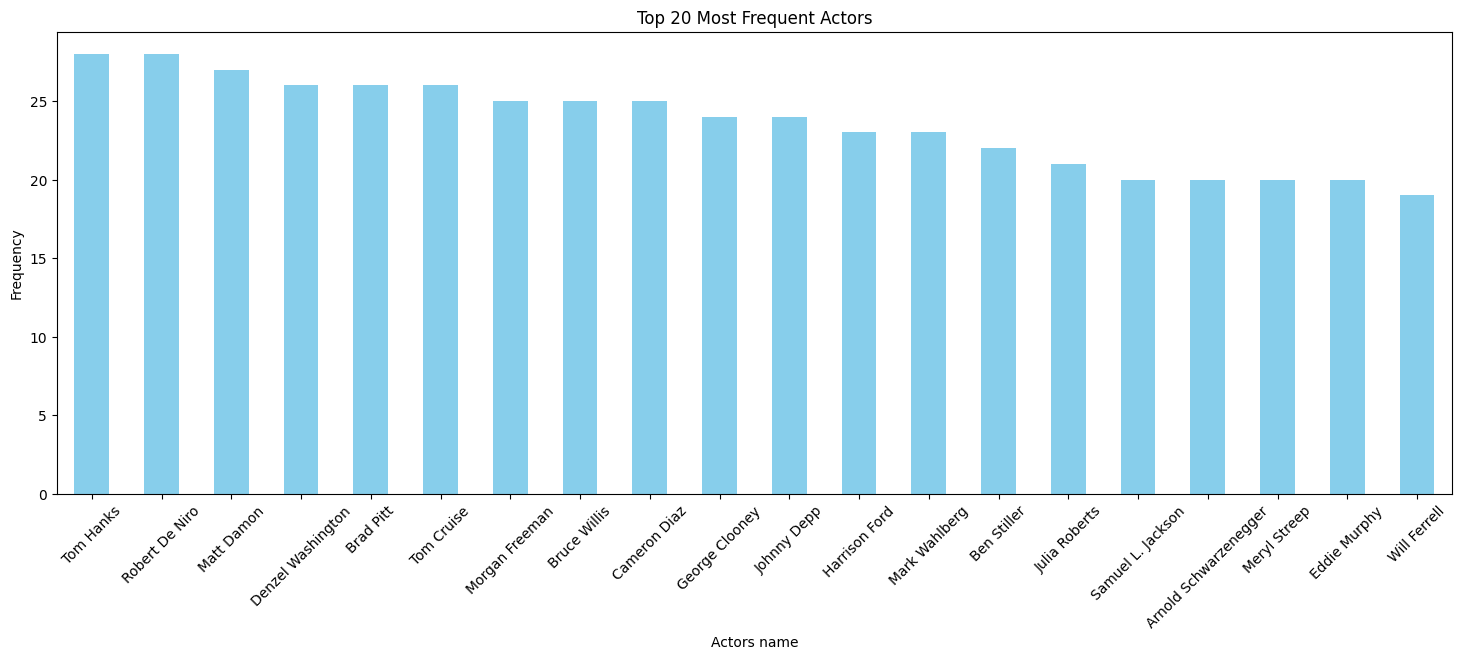

In [170]:
# Concatenate all three columns into a single Series
all_actors = pd.concat([df_profit['actor_1_name'], df_profit['actor_2_name'], df_profit['actor_3_name']])

# Count the occurrences of each actor
profit_actor_counts = all_actors.value_counts()

# Plot the top N most frequent actors
N = 20 # Change N to plot more or fewer actors
profit_top_names = profit_actor_counts.head(N)

plt.figure(figsize=(18, 6))
profit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent Actors')
plt.xlabel('Actors name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [175]:
list(profit_top_names.index)

['Tom Hanks',
 'Robert De Niro',
 'Matt Damon',
 'Denzel Washington',
 'Brad Pitt',
 'Tom Cruise',
 'Morgan Freeman',
 'Bruce Willis',
 'Cameron Diaz',
 'George Clooney',
 'Johnny Depp',
 'Harrison Ford',
 'Mark Wahlberg',
 'Ben Stiller',
 'Julia Roberts',
 'Samuel L. Jackson',
 'Arnold Schwarzenegger',
 'Meryl Streep',
 'Eddie Murphy',
 'Will Ferrell']

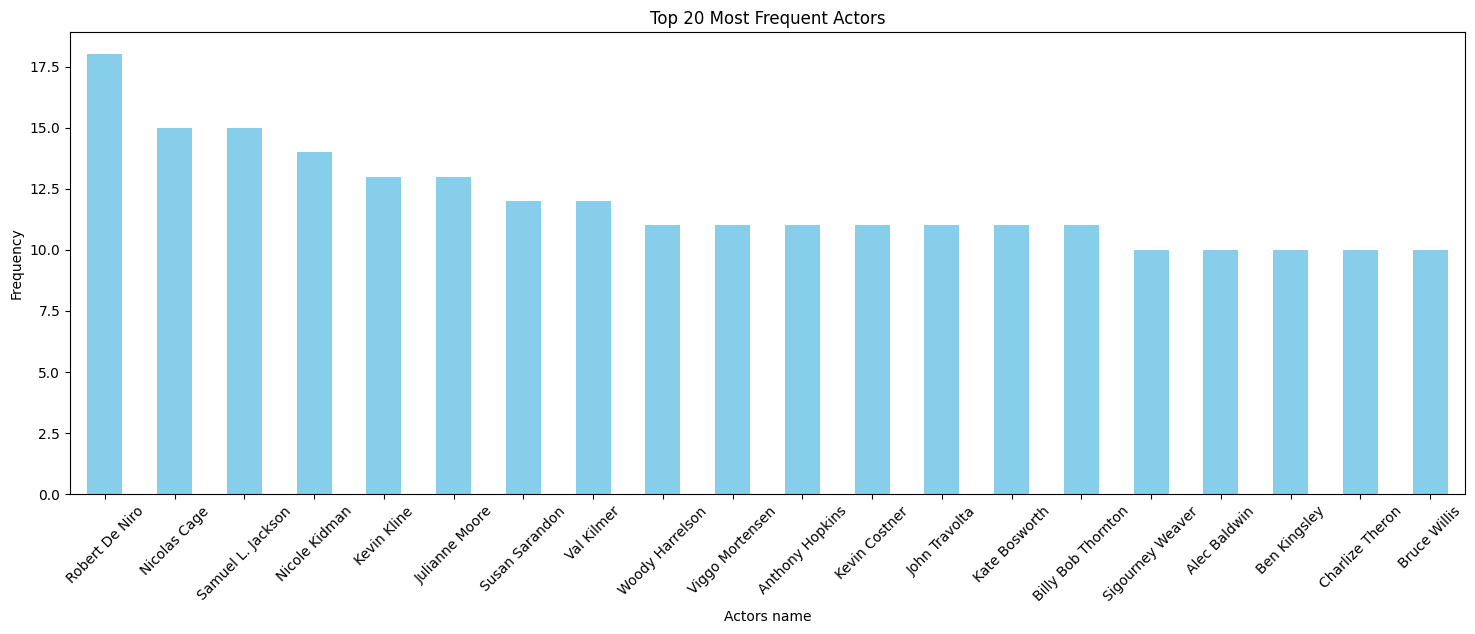

In [176]:
# Concatenate all three columns into a single Series
all_actors = pd.concat([df_no_profit['actor_1_name'], df_no_profit['actor_2_name'], df_no_profit['actor_3_name']])

# Count the occurrences of each actor
noprofit_actor_counts = all_actors.value_counts()

# Plot the top N most frequent actors
N = 20  # Change N to plot more or fewer actors
noprofit_top_names = noprofit_actor_counts.head(N)

plt.figure(figsize=(18, 6))
noprofit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent Actors')
plt.xlabel('Actors name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [185]:
def make_top_actors(actors_list):
    for actor in actors_list:
        if actor in list(profit_top_names.index) and actor not in list(noprofit_top_names.index):
            return 1
    return 0

In [193]:
make_top_actors(actors_list=['Shane Carruth', 'David Sullivan', 'Robert De Niro'])

0

In [194]:
df_preprocessed['top actors'] = df_preprocessed['actor_list'].apply(make_top_actors)

In [195]:
df_preprocessed['top actors'].value_counts()

top actors
0    4282
1     435
Name: count, dtype: int64

### diretors

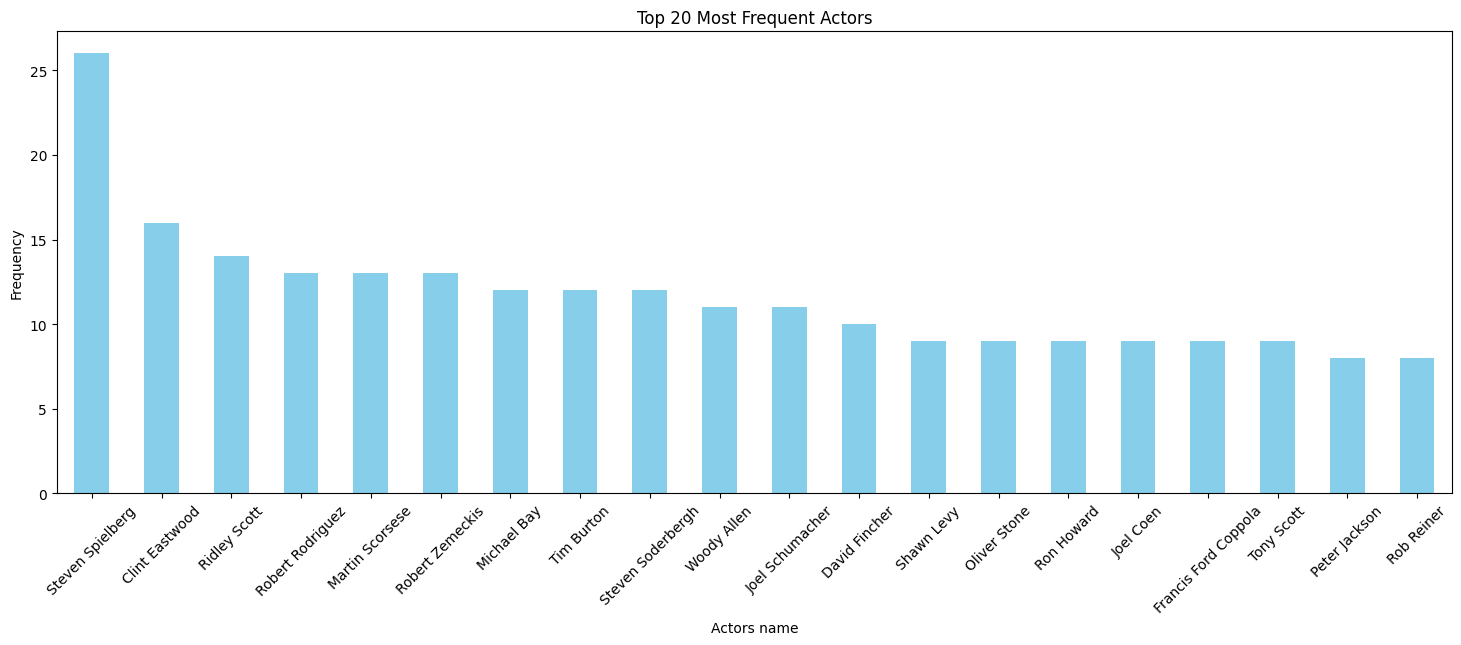

In [210]:
# Count the occurrences of each director
profit_director_counts = df_profit['director_name'].value_counts()

# Plot the top N most frequent actors
N = 20  # Change N to plot more or fewer actors
profit_top_names = profit_director_counts.head(N)

plt.figure(figsize=(18, 6))
profit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent directors - profit')
plt.xlabel('directors name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

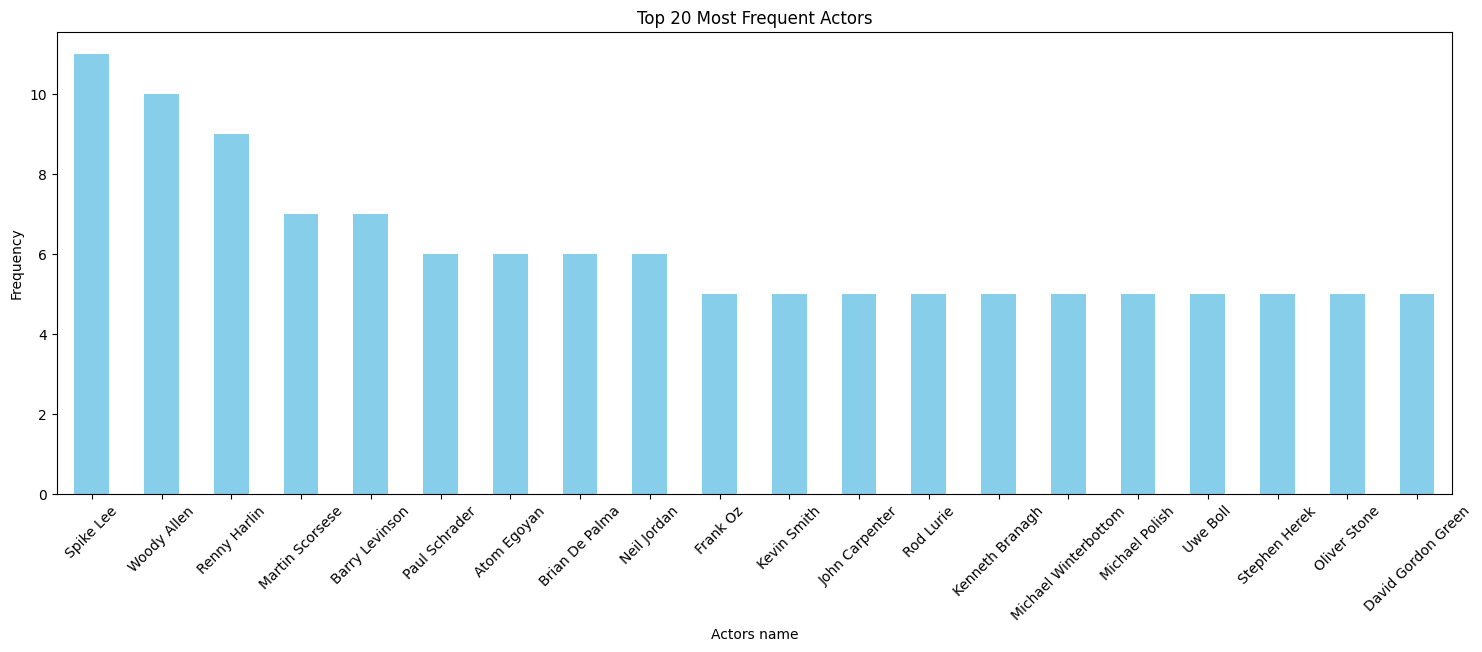

In [209]:
# Count the occurrences of each director
noprofit_director_counts = df_no_profit['director_name'].value_counts()

# Plot the top N most frequent actors
N = 20  # Change N to plot more or fewer actors
noprofit_top_names = noprofit_director_counts.head(N)

plt.figure(figsize=(18, 6))
noprofit_top_names.plot(kind='bar', color='skyblue')
plt.title(f'Top {N} Most Frequent directors')
plt.xlabel('director name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [211]:
def top_director(director):

    if director in list(profit_top_names.index) and director not in list(noprofit_top_names.index):
        return 1
    else:
        return 0

In [214]:
top_director(director='Shawn Levy')

1

In [215]:
df_preprocessed['top_director'] = df_preprocessed['director_name'].apply(top_director)

In [216]:
df_preprocessed['top_director'] .value_counts()

top_director
0    4482
1     235
Name: count, dtype: int64

### 2.3.4 language

In [217]:
count_nan_values(df_preprocessed, 'language')

Number of NaN values in 'language': 0


In [218]:
df_preprocessed = df_preprocessed.dropna(subset=['language'])

In [219]:
df_preprocessed['language'].value_counts()

language
English             4102
Français             108
Español               84
Deutsch               61
العربية               33
普通话                   32
Italiano              32
Pусский               31
Český                 30
广州话 / 廣州話             28
日本語                   23
हिन्दी                22
Português             17
Dansk                 12
                      12
Latin                  8
한국어/조선말                8
Nederlands             6
עִבְרִית               6
Afrikaans              5
svenska                5
ελληνικά               5
Norsk                  4
Română                 4
Magyar                 4
ภาษาไทย                4
Polski                 3
فارسی                  3
Kiswahili              3
Український            2
தமிழ்                  2
No Language            2
Tiếng Việt             2
Gaeilge                1
اردو                   1
Bahasa indonesia       1
??????                 1
Srpski                 1
Íslenska               1
Eesti           

In [220]:
df_preprocessed['language_summarized'] = df_preprocessed['language'].apply(lambda x: 'English' if x == 'English' else 'Not English')


In [221]:
df_preprocessed['language_summarized'].value_counts()

language_summarized
English        4102
Not English     615
Name: count, dtype: int64

### popularity

In [222]:
# Check for missing values
count_nan_values(df_preprocessed, 'popularity')

Number of NaN values in 'popularity': 0


In [223]:
# remove outlire

### vote_average

In [224]:
count_nan_values(df_preprocessed, 'vote_average')

Number of NaN values in 'vote_average': 0


In [225]:
df_preprocessed[df_preprocessed['vote_average'] < 0 ].shape

(0, 56)

In [226]:
df_preprocessed[df_preprocessed['vote_average'] > 10 ].shape

(0, 56)

In [227]:
# Define quartile thresholds for categorization
thresholds = [df_preprocessed['vote_average'].quantile(q) for q in [0, 0.25, 0.5, 0.75, 1]]
thresholds[0] = thresholds[0] - 0.001
thresholds[-1] = thresholds[-1] + 0.001

# Define labels for categories
labels = ['not_popular', 'below_avg', 'average', 'popular']

# Categorize 'vote_average'
df_preprocessed['vote_average_categorized'] = pd.cut(df_preprocessed['vote_average'], bins=thresholds, labels=labels)

# Display the categorized data
df_preprocessed['vote_average_categorized'].value_counts()

vote_average_categorized
not_popular    1240
average        1200
below_avg      1139
popular        1138
Name: count, dtype: int64

In [228]:
count_nan_values(df_preprocessed, 'vote_average_categorized')

Number of NaN values in 'vote_average_categorized': 0


### 2.3.3 plot_keywords

In [230]:
df_preprocessed['plot_keywords'][1]

"ocean|drug abuse|exotic island|east india trading company|love of one's life|traitor|shipwreck|strong woman|ship|alliance|calypso|afterlife|fighter|pirate|swashbuckler|aftercreditsstinger"

In [231]:
df_preprocessed['plot_keywords'][0]

'culture clash|future|space war|space colony|society|space travel|futuristic|romance|space|alien|tribe|alien planet|cgi|marine|soldier|battle|love affair|anti war|power relations|mind and soul|3d'

In [232]:
df_preprocessed['plot_keywords'][2]

'spy|based on novel|secret agent|sequel|mi6|british secret service|united kingdom'

In [233]:
df_preprocessed['plot_keywords'][3]

'dc comics|crime fighter|terrorist|secret identity|burglar|hostage drama|time bomb|gotham city|vigilante|cover-up|superhero|villainess|tragic hero|terrorism|destruction|catwoman|cat burglar|imax|flood|criminal underworld|batman'

In [234]:
def keywords_to_list(keywords):
    replaced_keywords = keywords.replace('|', ' ')
    return replaced_keywords.split(" ")

df_preprocessed['plot_keywords_list'] = df_preprocessed['plot_keywords'].apply(keywords_to_list)

In [235]:
df_preprocessed['plot_keywords'][3]

'dc comics|crime fighter|terrorist|secret identity|burglar|hostage drama|time bomb|gotham city|vigilante|cover-up|superhero|villainess|tragic hero|terrorism|destruction|catwoman|cat burglar|imax|flood|criminal underworld|batman'

In [236]:
df_preprocessed['plot_keywords_list'][3]

['dc',
 'comics',
 'crime',
 'fighter',
 'terrorist',
 'secret',
 'identity',
 'burglar',
 'hostage',
 'drama',
 'time',
 'bomb',
 'gotham',
 'city',
 'vigilante',
 'cover-up',
 'superhero',
 'villainess',
 'tragic',
 'hero',
 'terrorism',
 'destruction',
 'catwoman',
 'cat',
 'burglar',
 'imax',
 'flood',
 'criminal',
 'underworld',
 'batman']

In [77]:
## save dataframe

In [238]:
df_preprocessed.to_csv('df_preprocessed.csv', index=False)

# TD-IDF

In [242]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CN\AppData\Roaming\nltk_data...


True

In [243]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Additional stop words
custom_stopwords = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in custom_stopwords]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

# Preprocess each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer() # max_features=100

# Fit the vectorizer to the preprocessed data and transform the documents into a feature matrix
overview_features = vectorizer.fit_transform(preprocessed_documents)

# Convert the extracted features to a DataFrame
overview_features_df = pd.DataFrame(overview_features.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the features DataFrame with the original DataFrame
df_with_features = pd.concat([df_preprocessed, overview_features_df], axis=1)

In [244]:
df_with_features['ye']

,budget,genres,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,tagline,vote_average,num_voted_users,country,director_name,actor_1_name,actor_2_name,actor_3_name,profit,profit_categorized,,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,...,zinnemann,zinos,zion,zip,zira,zisman,zissou,ziyi,zod,zodiac,zoe,zohans,zohre,zohres,zombie,zombieland,zone,zoo,zooey,zookeeper,zookeepers,zoolander,zoologist,zoom,zoozie,zorin,zorro,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,übertarget
0,237.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787.965087,162.0,Enter the World of Pandora.,7.2,11800.0,United States of America,James Cameron,Sam Worthington,Zoe Saldana,Sigourney Weaver,2550.965087,profit,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,300.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961.000000,169.0,"At the end of the world, the adventure begins.",6.9,4500.0,United States of America,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley,661.000000,profit,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,245.0,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880.674609,148.0,A Plan No One Escapes,6.3,4466.0,United Kingdom,Sam Mendes,Daniel Craig,Christoph Waltz,Léa Seydoux,635.674609,profit,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,250.0,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084.939099,165.0,The Legend Ends,7.6,9106.0,United States of America,Christopher Nolan,Christian Bale,Michael Caine,Gary Oldman,834.939099,profit,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.0,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284.139100,132.0,"Lost in our world, found in another.",6.1,2124.0,United States of America,Andrew Stanton,Taylor Kitsch,Lynn Collins,Samantha Morton,24.139100,no profit,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
df_with_features.to_csv('df_with_features.csv', index=False)

In [ ]:
# Get the feature names (tokens) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF matrix
tfidf_matrix = X.toarray()

# Calculate the mean TF-IDF score for each token across all documents
mean_tfidf_scores = np.mean(tfidf_matrix, axis=0)

# Create a dictionary mapping each token to its mean TF-IDF score
token_tfidf_scores = dict(zip(feature_names, mean_tfidf_scores))

# Sort the tokens by their mean TF-IDF scores
sorted_tokens = sorted(token_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the sorted tokens with their mean TF-IDF scores
for token, score in sorted_tokens:
    print(f"Token: {token}, Mean TF-IDF Score: {score}")

In [ ]:
sorted_tokens

In [ ]:
df_preprocessed.head()

In [ ]:
sorted_tokens[i][0]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample text data
documents = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the data and transform the documents into a feature matrix
X = vectorizer.fit_transform(documents)

# Print the feature matrix
print(X.toarray())

# Print the vocabulary (mapping of terms to feature indices)
print(vectorizer.vocabulary_)


In [ ]:
# Print the vocabulary (mapping of terms to feature indices) and their counts
vocab = vectorizer.vocabulary_
for word, idx in vocab.items():
    print(f"Word: {word}, Count: {X[:, idx].sum()}")

In [ ]:
# Sample text data
documents = [
    ["This", "is", "the", "first", "document."],
    ["This", "document", "is", "the", "second", "document."],
    ["And", "this", "is", "the", "third", "one."],
    ["Is", "this", "the", "first", "document?"],
]

# Convert the list of lists into list of strings
documents = [" ".join(doc) for doc in documents]

# Create a CountVectorizer object with n-gram range from unigrams to trigrams
vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit the vectorizer to the data and transform the documents into a feature matrix
X = vectorizer.fit_transform(documents)

# Print the feature matrix
print(X.toarray())

# Print the vocabulary (mapping of terms to feature indices)
print(vectorizer.vocabulary_)

In [ ]:
# Print the vocabulary (mapping of terms to feature indices) and their counts
vocab = vectorizer.vocabulary_
for word, idx in vocab.items():
    print(f"Word: {word}, Count: {X[:, idx].sum()}")

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Sample text data
documents = [
    "Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language.",
    "NLP techniques allow computers to process and understand human language in a meaningful way.",
    "Common NLP tasks include text classification, sentiment analysis, and machine translation.",
    "Stop words such as 'the', 'is', 'and', etc., are often removed during NLP preprocessing to focus on meaningful content.",
]

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in ENGLISH_STOP_WORDS)
    return text

# Preprocess each document
preprocessed_documents = [preprocess_text(doc) for doc in documents]

# Create a CountVectorizer object with n-gram range from unigrams to trigrams
vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit the vectorizer to the preprocessed data and transform the documents into a feature matrix
X = vectorizer.fit_transform(preprocessed_documents)

# Print the feature matrix
print(X.toarray())

# Print the vocabulary (mapping of terms to feature indices)
print(vectorizer.vocabulary_)


In [ ]:
preprocessed_documents

In [ ]:
import numpy as np




In [ ]:
type(df_preprocessed['overview'][0])

In [ ]:
preprocess_text(df_preprocessed['overview'][0])

In [ ]:
for i in df_preprocessed['overview']:
    if type(i) != str:
        print(i)
        print(type(i))

In [ ]:
feature_names